In [1]:
import netket as nk
import netket.experimental as nkx
import netket.nn as nknn

from math import pi

from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc

from vmc_torch.fermion_utils import generate_random_fpeps, product_bra_state, get_amp
import quimb.tensor as qtn
from autoray import do
import symmray as sr
import pickle
import os
os.environ['NUMBA_NUM_THREADS'] = '20'

# Define the lattice shape
L = 4  # Side of the square
Lx = int(L)
Ly = int(L)
# graph = nk.graph.Square(L)
graph = nk.graph.Grid([Lx,Ly], pbc=False)
N = graph.n_nodes


# Define the fermion filling and the Hilbert space
N_f = int(Lx*Ly)
hi = nkx.hilbert.SpinOrbitalFermions(N, s=1/2, n_fermions=N_f)
# hi = nkx.hilbert.SpinOrbitalFermions(N, s=1/2, n_fermions_per_spin=(N_f//2,N_f//2))

# Define the Hubbard Hamiltonian
t = 1.0
U = 8.0
mu = 0.0

H = 0.0
for (i, j) in graph.edges(): # Definition of the Hubbard Hamiltonian
    for spin in (1,-1):
        H -= t * (cdag(hi,i,spin) * c(hi,j,spin) + cdag(hi,j,spin) * c(hi,i,spin))
for i in graph.nodes():
    H += U * nc(hi,i,+1) * nc(hi,i,-1)


# # Exact diagonalization of the Hamiltonian for benchmark
# sp_h = H.to_sparse() # Convert the Hamiltonian to a sparse matrix
# from scipy.sparse.linalg import eigsh
# from scipy.linalg import eigh
# try:
#     eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
#     E_gs = eig_vals[0]
#     psi_gs = eig_vecs[:,0]
# except:
#     eig_val, eig_vec = eigh(sp_h.toarray())
#     E_gs = eig_val
#     psi_gs = eig_vec[:,0]

# print("Exact ground state energy per site:", E_gs/N)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
import jax
import numpy as np
random_seed = np.random.randint(2**32 - 1)
config = hi.random_state(key=jax.random.PRNGKey(random_seed))

# --- Utils ---
def from_netket_config_to_quimb_config(netket_configs):
    def func(netket_config):
        """Translate netket spin-1/2 config to tensor network product state config"""
        total_sites = len(netket_config)//2
        spin_up = netket_config[:total_sites]
        spin_down = netket_config[total_sites:]
        sum_spin = spin_up + spin_down
        quimb_config = np.zeros(total_sites, dtype=int)
        for i in range(total_sites):
            if sum_spin[i] == 0:
                quimb_config[i] = 0
            if sum_spin[i] == 2:
                quimb_config[i] = 3
            if sum_spin[i] == 1:
                if spin_down[i] == 1:
                    quimb_config[i] = 1
                else:
                    quimb_config[i] = 2
        return quimb_config
    if len(netket_configs.shape) == 1:
        return func(netket_configs)
    else:
        # batched
        return np.array([func(netket_config) for netket_config in netket_configs])

def from_quimb_config_to_netket_config(quimb_config):
    """Translate tensor network product state config to netket spin-1/2 config"""
    total_sites = len(quimb_config)
    spin_up = np.zeros(total_sites, dtype=int)
    spin_down = np.zeros(total_sites, dtype=int)
    for i in range(total_sites):
        if quimb_config[i] == 0:
            spin_up[i] = 0
            spin_down[i] = 0
        if quimb_config[i] == 1:
            spin_up[i] = 0
            spin_down[i] = 1
        if quimb_config[i] == 2:
            spin_up[i] = 1
            spin_down[i] = 0
        if quimb_config[i] == 3:
            spin_up[i] = 1
            spin_down[i] = 1
    return np.concatenate((spin_up, spin_down))

# Spinful PEPS

In [13]:
D = 4
seed = 2
symmetry = 'U1'
spinless = False
peps = generate_random_fpeps(Lx, Ly, D=D, seed=2, symmetry=symmetry, Nf=N_f, spinless=spinless)[0]
edges = qtn.edges_2d_square(Lx, Ly, cyclic=False)
site_info = sr.utils.parse_edges_to_site_info(
    edges,
    D,
    phys_dim=4,
    site_ind_id="k{},{}",
    site_tag_id="I{},{}",
)

terms = {
    (sitea, siteb): sr.fermi_hubbard_local_array(
        t=t, U=U, mu=mu,
        symmetry=symmetry,
        coordinations=(
            site_info[sitea]['coordination'],
            site_info[siteb]['coordination'],
        ),
    ).fuse((0, 1), (2, 3))
    for (sitea, siteb) in peps.gen_bond_coos()
}

ham = qtn.LocalHam2D(Lx, Ly, terms)
from functools import partial
su = qtn.SimpleUpdateGen(
    peps, 
    ham, 
    compute_energy_per_site=True, 
    D=D, 
    compute_energy_opts={"max_distance":1}, 
    gate_opts={'cutoff':1e-10},
    # compute_energy_fn=qtn.PEPS.compute_local_expectation,
    # compute_energy_fn = partial(qtn.PEPS.compute_local_expectation, terms=ham.terms, normalized=True),
    # compute_energy_fn = lambda x: x._psi.compute_local_expectation(terms=x.ham.terms, normalized=True),
    )
# # cluster energies may not be accuracte yet
# su.evolve(50, tau=0.3)
# su.evolve(50, tau=0.1)
# su.evolve(50, tau=0.03)
# peps = su.get_state()
# gs = su.get_state()

# peps.equalize_norms_(value=1)

# # save the state
# params, skeleton = qtn.pack(peps)

# import os
# os.makedirs(f'../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}', exist_ok=True)

# with open(f'../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_skeleton.pkl', 'wb') as f:
#     pickle.dump(skeleton, f)
# with open(f'../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_su_params.pkl', 'wb') as f:
#     pickle.dump(params, f)

In [16]:
from vmc_torch.experiment.tn_model import fTNModel, fTN_NN_proj_variable_Model
import torch
peps.apply_to_arrays(torch.tensor)
peps_model = fTN_NN_proj_variable_Model(peps, max_bond=4, nn_hidden_dim=32,)
peps_model.proj_params_vec_len


28

In [6]:
peps = su.get_state()
peps.compute_local_expectation(ham.terms, normalized=True, max_bond=32)/N

-0.7866901561460139

In [5]:
random_config = from_netket_config_to_quimb_config(hi.random_state(key=jax.random.PRNGKey(random_seed)))
amp = peps.get_amp(random_config)

In [7]:
import pyinstrument

with pyinstrument.Profiler() as prof:
    peps.get_amp(random_config).contract()

prof.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 16:15:03  Samples:  40
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.041     CPU time: 0.041
/   _/                      v4.7.3

Profile at /tmp/ipykernel_804/1337532818.py:3

0.040 <module>  ../../../../../tmp/ipykernel_804/1337532818.py:3
├─ 0.025 fPEPS.get_amp  ../fermion_utils.py:220
│  ├─ 0.023 TensorNetwork.contract  quimb/tensor/tensor_core.py:8297
│  │  └─ 0.023 TensorNetwork.contract_tags  quimb/tensor/tensor_core.py:8187
│  │     ├─ 0.022 wrapper  functools.py:883
│  │     │  └─ 0.022 tensor_contract  quimb/tensor/tensor_core.py:207
│  │     │     ├─ 0.020 array_contract  quimb/tensor/contraction.py:273
│  │     │     │  └─ 0.020 array_contract  cotengra/interface.py:735
│  │     │     │        [7 frames hidden]  cotengra, functools, autoray, importl...
│  │     │     │           0.017 wrapper  functools.py:883
│  │     │     │           └─ 0.015 tensordot_fermionic  symmray/fermionic_core.py:725
│  │     │     │             

In [59]:
from symmray.symmetries import  calc_phase_permutation
import numpy
all_configs = hi.all_states()
if not spinless:
    # all_configs = [from_netket_config_to_quimb_config(config) for config in all_configs]
    all_configs = from_netket_config_to_quimb_config(all_configs)
phase_list = []
axes = tuple(range(peps.nsites - 1, -1, -1))
parity_map = {0:0, 1:1, 2:1, 3:0}

for config in all_configs:
    config_parity = np.array([parity_map[config[i]] for i in range(len(config))])
    perm_phase = calc_phase_permutation(tuple(config_parity), axes)
    # print(config, perm_phase, config_parity)
    phase_list.append(perm_phase)

ket_list = [product_bra_state(peps, config, check=True, reverse=False, dualness=False) for config in all_configs]
bra1_list = [product_bra_state(peps, config, check=True, reverse=False, dualness=True) for config in all_configs]
bra_list = [product_bra_state(peps, config, check=True, reverse=False, dualness=False).conj() for config in all_configs]
hamiltonian = H.to_dense()

In [60]:
def check_oddpos(tn):
    oddpos_list = []
    try:
        for array in tn.arrays:
            oddpos_list.append(array.oddpos)
        return oddpos_list
    except:
        oddpos_list.append(tn.data.oddpos)
        return oddpos_list

In [61]:
from symmray.symmetries import  calc_phase_permutation
from vmc_torch.fermion_utils import get_spinful_charge_map
import itertools

def calc_phase_hopping(where, config):
    site1, site2 = where
    site_ind1 = site1[0]*Ly + site1[1]
    site_ind2 = site2[0]*Ly + site2[1]
    parity_map = {0:0, 1:1, 2:1, 3:2}
    parity_config = np.array([parity_map[config[i]] for i in range(len(config))])
    if sum(parity_config[site_ind1+1:site_ind2])%2 == 0:
        return 1
    else:
        return -1
def calc_reverse_phase(config):
    axes = tuple(range(len(config) - 1, -1, -1))
    parity_map = {0:0, 1:1, 2:1, 3:0}
    config_parity = np.array([parity_map[config[i]] for i in range(len(config))])
    perm_phase = calc_phase_permutation(tuple(config_parity), axes)
    perm_phase *= (-1)**np.count_nonzero(np.array(config)==3)
    return perm_phase

In [62]:
new_ham = np.zeros_like(hamiltonian)
raw_matrix = np.zeros_like(hamiltonian)
for i, j in itertools.product(range(len(bra_list)), repeat=2):
    if hamiltonian[i,j] == 0:
        continue
    bra = bra_list[i]
    ket = bra_list[j].conj()
    config = all_configs[j]
    matrix_element = 0
    for where, G in ham.terms.items():
        x = (bra|ket.gate(G, where=where, contract=True)).contract()
        if x!=0:
            raw_matrix[i,j] += x
            # x *= calc_reverse_phase(config)
            if i!=j:
                x *= calc_phase_hopping(where, config)
            matrix_element += x
    new_ham[i,j] = matrix_element * (-1)**N_f

# T--->---: Dual, ind-
# T---<---: NOT dual, ind+

# T1---<---T2: no parity factor, +-
# T1--->---T2: has parity factor, -+

In [63]:
# Netket Hamiltonian energy check
import numpy as np
all_configs = hi.all_states()
if not spinless:
    # all_configs = [from_netket_config_to_quimb_config(config) for config in all_configs]
    all_configs = from_netket_config_to_quimb_config(all_configs)

psi_vec = np.array([gs.get_amp(config).contract() for config in all_configs])
# psi_vec = np.array([(bra|gs).contract() for bra in bra_list])
psi_vec_ket = np.array([(ket.conj()|gs).contract() for ket in ket_list])
psi_vec = psi_vec/np.linalg.norm(psi_vec)
psi_vec_ket = psi_vec_ket/np.linalg.norm(psi_vec_ket)

print((psi_vec.conj().T @ (new_ham @ psi_vec))/N, (psi_vec.conj().T @ (hamiltonian @ psi_vec))/N, (psi_vec.conj().T @ (raw_matrix @ psi_vec))/N)

-0.2505913357410974 0.31510058433961347 0.030282680557498384


In [64]:
gs.get_amp(all_configs[0]).contract(), peps.get_amp(all_configs[0]).contract()

(np.float64(0.0017441641935983883), np.float64(0.0017441641935983883))

In [19]:
def detect_hopping(configi, configj):
    site_ls =  (configi-configj).nonzero()[0]
    if len(site_ls) == 2:
        return site_ls
    else:
        return None

def calc_reverse_phase(config):
    axes = tuple(range(len(config) - 1, -1, -1))
    parity_map = {0:0, 1:1, 2:1, 3:0}
    config_parity = np.array([parity_map[config[i]] for i in range(len(config))])
    perm_phase = calc_phase_permutation(tuple(config_parity), axes)
    perm_phase *= (-1)**np.count_nonzero(np.array(config)==3)
    return perm_phase


def detect_hopping(configi, configj):
    site_ls =  (configi-configj).nonzero()[0]
    if len(site_ls) == 2:
        return site_ls
    else:
        return None

def calc_phase_netket(configi, configj):
    """Calculate the phase factor for the matrix element in the netket basis, where all spin-up spins are placed before all spin-down spins"""
    hopping = detect_hopping(configi, configj)
    if hopping is not None:
        netket_config_i = from_quimb_config_to_netket_config(configi)
        netket_config_j = from_quimb_config_to_netket_config(configj)
        netket_site_i, netket_site_j = (netket_config_i - netket_config_j).nonzero()[0]
        phase = (-1)**(sum(netket_config_i[netket_site_i+1:netket_site_j])%2)
        return phase
    else:
        return 1

def calc_phase_symmray(configi, configj):
    """Calculate the operator matrix element phase in symmray, assuming local basis convention for spinful fermion is (|up, down>).
    Globally, this convention gives a staggered spin configuration (|dududu...>) when the configuration is flattened to 1D."""
    hopping = detect_hopping(configi, configj)
    if hopping is not None:
        netket_config_i = from_quimb_config_to_netket_config(configi)
        netket_config_j = from_quimb_config_to_netket_config(configj)
        config_i_spin_up =netket_config_i[:len(netket_config_i)//2]
        config_i_spin_down =netket_config_i[len(netket_config_i)//2:]
        config_j_spin_up =netket_config_j[:len(netket_config_j)//2]
        config_j_spin_down =netket_config_j[len(netket_config_j)//2:]
        symmray_config_i = tuple()
        symmray_config_j = tuple()
        for i in range(len(config_i_spin_up)):
            symmray_config_i += (config_i_spin_down[i], config_i_spin_up[i])
            symmray_config_j += (config_j_spin_down[i], config_j_spin_up[i])
        symmray_site_i, symmray_site_j = (np.asarray(symmray_config_i) - np.asarray(symmray_config_j)).nonzero()[0]
        phase = (-1)**(sum(symmray_config_i[symmray_site_i+1:symmray_site_j])%2)
        return phase
    else:
        return 1

def calc_phase_correction_netket_symmray(configi, configj):
    phase_netket = calc_phase_netket(configi, configj)
    phase_symmray = calc_phase_symmray(configi, configj)
    return phase_netket/phase_symmray

In [20]:
# i_ls, j_ls = (new_ham[:20,:20]-hamiltonian[:20,:20]).nonzero()
# i_ls, j_ls = range(20), range(20)
new_ham1 = np.zeros_like(hamiltonian)
corrected_hamiltonian = np.zeros_like(hamiltonian)
for i, j in itertools.product(range(new_ham.shape[0]), repeat=2):
    if detect_hopping(all_configs[i], all_configs[j]) is not None and hamiltonian[i,j]!=0:
        # print(all_configs[i], all_configs[j])
        config_i, config_j = all_configs[i], all_configs[j]
        site_i, site_j = detect_hopping(all_configs[i], all_configs[j])

        new_ham1[i,j] = calc_phase_symmray(config_i,config_j)*(-t)
        corrected_hamiltonian[i,j] = hamiltonian[i,j]*calc_phase_correction_netket_symmray(config_i, config_j)
        # print(corrected_hamiltonian[i,j] == hamiltonian[i,j]*calc_phase_correction_netket_symmray(config_j, config_i))
    else:
        if i==j:
            # print(new_ham[i,j]==hamiltonian[i,j], new_ham[i,j], hamiltonian[i,j])
            double_occupied_nsite = np.count_nonzero(np.array(all_configs[i])==3)
            # print(double_occupied_nsite)
            new_ham1[i,j] = U*double_occupied_nsite
            corrected_hamiltonian[i,j] = U*double_occupied_nsite

In [21]:
for i in range(len(all_configs)):
    test_config = all_configs[i]
    test_eta, H_etasigmas = H.get_conn(from_quimb_config_to_netket_config(test_config))
    H_etasigmas_0 = H_etasigmas.copy()
    correction_vector = np.array([calc_phase_correction_netket_symmray(test_config, from_netket_config_to_quimb_config(eta)) for eta in test_eta])
    H_etasigmas *= correction_vector

    # print(H_etasigmas==H_etasigmas_0)

In [22]:
x_list, y_list = (new_ham-new_ham1).nonzero()
for x, y in zip(x_list, y_list):
    print(all_configs[x], all_configs[y], new_ham[x,y], new_ham1[x,y])

In [23]:
psi_vec @ (new_ham1 @ psi_vec)/N, psi_vec @ (corrected_hamiltonian @ psi_vec)/N

(np.float64(-0.23409300767191932), np.float64(-0.23409300767191932))

In [27]:
peps.get_amp(all_configs[0]).contract()

np.float64(0.022971751148022756)

In [24]:
norm, ket, bra = peps.make_norm(return_all=True)
E_sum = 0
for where, G in ham.terms.items():
    tn = bra|ket.gate(G, where=where, contract=False)
    print(where, tn.contract()/norm.contract())
    E_sum += tn.contract()/norm.contract()
print(E_sum/N)
where, G = list(ham.terms.items())[0]

((0, 0), (0, 1)) 0.10269596125131342
((0, 0), (1, 0)) -0.5706058933253856
((0, 1), (1, 1)) -0.5711794703374962
((1, 0), (1, 1)) 0.10271737172389099
-0.23409300767191932


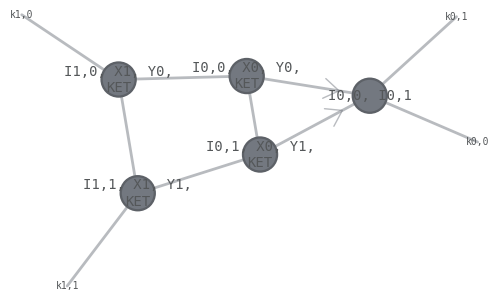

In [29]:
ket.gate(G, where=where, contract=False).draw()

In [30]:
import itertools
# site 0 -- site 1
where, G = list(ham.terms.items())[0]
new_ham0 = np.zeros_like(hamiltonian)
E_test=0
for i, j in itertools.product(range(len(bra_list)), repeat=2):
    bra = bra_list[i]
    ket = ket_list[j]
    x = (bra|ket.gate(G, where=where, contract=True)).contract()
    if x!=0:
        # print(all_configs[i], all_configs[j], x, hamiltonian[i,j])
        x *= calc_reverse_phase(all_configs[i])
        E_test += x * psi_vec[i].conj() * psi_vec[j]
        new_ham0[i,j] += x
E_test

np.float64(0.06705340694576555)

In [82]:
# site 0 -- site 2
where, G = list(ham.terms.items())[1]
E_test=0
for i, j in itertools.product(range(len(bra_list)), repeat=2):
    bra = bra_list[i]
    # ket = ket_list[j]
    ket = bra_list[j].conj()
    x = (bra|ket.gate(G, where=where, contract=True)).contract()
    if parity_map[all_configs[j][1]]==1 and x!=0 and i!=j:
        x*= -1
    if x!=0:
        # print(all_configs[i], all_configs[j], psi_vec[i].conj(), psi_vec[j], x)
        x *= calc_reverse_phase(all_configs[i])
        E_test += x * psi_vec[i].conj() * psi_vec[j]
        new_ham0[i,j] += x
E_test

np.float64(-0.5363725895655636)

## Important:
when computing matrix element using product states with odd parity tensors, on-site contraction of 2 product states will throw the entire tensors+oddpos away, resulting in lost track of the tensor positions. Has to manually compute the permutation phase or cotract the two product states seperately first before computing the overlap (which is expensive).

In [87]:
for i, j in itertools.product(range(len(bra_list)), repeat=2):
    bra = bra_list[i]
    ket = ket_list[j]
    # ket = bra_list[j].conj()
    x = (bra|ket.gate(G, where=where, contract=True)).contract()
    if parity_map[all_configs[j][1]]==1 and x!=0 and i!=j:
        break
(bra|ket.gate(G, where=where, contract=True)).contract(), (bra.contract()|ket.gate(G, where=where, contract=True).contract()).contract()

(-1.0, 1.0)

In [84]:
(bra|ket.gate(G, where=where, contract=True)).contract(get='path-info'), (bra|ket.gate(G, where=where, contract=True)).contract(get='tree').get_path()

(  Complete contraction:  a,b,c,d,b,d,ac->
          Naive scaling:  4
      Optimized scaling:  2
       Naive FLOP count:  1.792e+3
   Optimized FLOP count:  6.100e+1
    Theoretical speedup:  2.938e+1
   Largest intermediate:  4.000e+0 elements
 --------------------------------------------------------------------------------
 scaling        BLAS                current                             remaining
 --------------------------------------------------------------------------------
    1            DOT                  b,b->                         a,c,d,d,ac,->
    1            DOT                  d,d->                            a,c,ac,,->
    0   OUTER/EINSUM                    ,->                             a,c,ac,->
    1   OUTER/EINSUM                  ,a->a                              c,ac,a->
    2           GEMM                a,ac->c                                 c,c->
    1            DOT                  c,c->                                    ->,
 ((1, 4), (2,

In [86]:
(bra.contract()|ket.gate(G, where=where, contract=True).contract()).contract(get='path-info')

  Complete contraction:  abcd,bdac->
         Naive scaling:  4
     Optimized scaling:  4
      Naive FLOP count:  5.120e+2
  Optimized FLOP count:  5.120e+2
   Theoretical speedup:  1.000e+0
  Largest intermediate:  1.000e+0 elements
--------------------------------------------------------------------------------
scaling        BLAS                current                             remaining
--------------------------------------------------------------------------------
   4     DOT/EINSUM            bdac,abcd->                                    ->

In [109]:
# site 1 -- site 3
where, G = list(ham.terms.items())[2]
E_test=0
for i, j in itertools.product(range(len(bra_list)), repeat=2):
    bra = bra_list[i]
    ket = ket_list[j]
    x = (bra|ket.gate(G, where=where, contract=True)).contract()
    if parity_map[all_configs[j][2]]==1 and x!=0:
        x*= -1
    if x!=0:
        # print(all_configs[i], all_configs[j], psi_vec[i].conj(), psi_vec[j], x)\
        x *= calc_reverse_phase(all_configs[i])
        E_test += x * psi_vec[i].conj() * psi_vec[j]
        new_ham0[i,j] += x
E_test

np.float64(-0.9472856447325668)

In [108]:
# site 2 -- site 3
where, G = list(ham.terms.items())[3]
E_test=0
for i, j in itertools.product(range(len(bra_list)), repeat=2):
    bra = bra_list[i]
    ket = ket_list[j]
    x = (bra|ket.gate(G, where=where, contract=True)).contract()
    if x!=0:
        # print(all_configs[i], all_configs[j], psi_vec[i].conj(), psi_vec[j], x)
        x *= calc_reverse_phase(all_configs[i])
        E_test += x * psi_vec[i].conj() * psi_vec[j]
        new_ham0[i,j] += x
E_test

np.float64(-0.28001258550654573)

In [348]:
psi_vec @ (new_ham0 @ psi_vec)/N

np.float64(-0.5514377150952766)

In [25]:
N_terms = {
    site: sr.fermi_number_operator_spinful_local_array(
        symmetry=symmetry
    )
    for site in peps.gen_site_coos()
}
gs = su.get_state()
gs.compute_local_expectation(
    N_terms, normalized=True, max_bond=64,
)/N, gs.compute_local_expectation(
    ham.terms, normalized=True, max_bond=128,
)/N,

(np.float64(0.12499999999999986), np.float64(-0.3220275415290801))

In [ ]:
from symmray.fermionic_local_operators import  build_local_fermionic_elements, build_local_fermionic_dense, get_spinful_indexmap, build_local_fermionic_array
au = sr.FermionicOperator("au")
ad = sr.FermionicOperator("ad")
basis_a = ((), (ad.dag,), (au.dag,), (au.dag, ad.dag))
bases = (basis_a,)
indexmap = get_spinful_indexmap('U1')
terms = (
    (1, (au.dag,)),
)

build_local_fermionic_elements(terms, bases)

# Energy check

In [ ]:
# Netket Hamiltonian energy check
import numpy as np
all_configs = hi.all_states()
if not spinless:
    # all_configs = [from_netket_config_to_quimb_config(config) for config in all_configs]
    all_configs = from_netket_config_to_quimb_config(all_configs)

psi_vec = np.array([gs.get_amp(config).contract() for config in all_configs])

hamiltonian = H.to_dense()
psi_vec = psi_vec/np.linalg.norm(psi_vec)
print((psi_vec.conj().T @ (hamiltonian @ psi_vec))/N)

In [ ]:
# Quimb energy check
gs.compute_local_expectation(
    ham.terms, normalized=True, max_bond=64,
)/N

In [ ]:
psi_gs, psi_vec

In [ ]:
def to_array_check(peps):
    all_config = hi.all_states()
    if not spinless:
        all_config = [from_netket_config_to_quimb_config(config) for config in all_config]
    psi = np.asarray([peps.get_amp(config, conj=True).contract() for config in all_config])
    # print(psi)
    psi = psi/do('linalg.norm', psi)
    return psi

def compute_energy_check(model, hamiltonian):
    psi_gs = to_array_check(model)
    return psi_gs.conj().T@(hamiltonian@psi_gs)/N

hamiltonian = H

compute_energy_check(peps, hamiltonian)

In [ ]:
n_site = N_terms[(0,0)]
inda, indb = 'a', 'b'
product_state1 = sr.FermionicArray.from_blocks(blocks={(2,):np.array([1])}, duals=(True,),symmetry='U1', charge=2, oddpos=1)
product_state2 = sr.FermionicArray.from_blocks(blocks={(2,):np.array([1])}, duals=(True,),symmetry='U1', charge=2, oddpos=2)
n_site_tensor = qtn.Tensor(data=n_site, inds=(inda,indb), tags=(f'I{inda},{indb}',))
product_state_tensor1 = qtn.Tensor(data=product_state1, inds=(inda,), tags=(f'I{inda}',))
product_state_tensor2 = qtn.Tensor(data=product_state2, inds=(indb,), tags=(f'I{indb}',))
(product_state_tensor1.conj()|n_site_tensor|product_state_tensor2).contract(), (product_state_tensor1|product_state_tensor1.conj()).contract(), (n_site_tensor|product_state_tensor1.conj()).contract().data.to_dense()

# Cyclic PEPS

In [5]:
peps = qtn.PEPS.rand(4, 4, 4, cyclic=True)

In [13]:
# SU in quimb
D = 4
seed = 2
symmetry = 'Z2'
cyclic = True
# peps, parity_config = generate_random_fpeps(Lx, Ly, D, seed, symmetry, Nf=N_f)

edges = qtn.edges_2d_square(Lx, Ly, cyclic=cyclic)
site_info = sr.utils.parse_edges_to_site_info(
    edges,
    D,
    phys_dim=2,
    site_ind_id="k{},{}",
    site_tag_id="I{},{}",
)

peps = qtn.TensorNetwork()
parity_config = np.zeros(Lx*Ly, dtype=int)
rng = np.random.default_rng(seed)
for site, info in sorted(site_info.items()):
    tid = site[0] * Ly + site[1]
    # bond index charge distribution
    block_indices = [
        sr.BlockIndex({0: d // 2, 1: d // 2}, dual=dual)
        for d, dual in zip(info["shape"][:-1], info["duals"][:-1])
    ]

    # physical index
    p = info['shape'][-1]
    block_indices.append(
        sr.BlockIndex({0: p // 2, 1: p // 2}, dual=info["duals"][-1])
    )

    data = sr.Z2FermionicArray.random(
        block_indices,
        charge=1 if parity_config[tid] else 0,
        seed=rng,
        oddpos=2*tid,
    )

    peps |= qtn.Tensor(
        data=data,
        inds=info["inds"],
        tags=info["tags"],
    )

# required to view general TN as an actual PEPS
for i, j in site_info:
    peps[f"I{i},{j}"].add_tag([f"X{i}", f"Y{j}"])

peps.view_as_(
    fPEPS,
    site_ind_id="k{},{}",
    site_tag_id="I{},{}",
    x_tag_id="X{}",
    y_tag_id="Y{}",
    Lx=Lx,
    Ly=Ly,
)
peps = peps.copy() # set symmetry during initialization

In [ ]:
peps.draw()